<a href="https://colab.research.google.com/github/hj56775/Study_GAN/blob/main/CycleGAN/CycleGAN%2BCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-addons

In [ ]:
%%bash

FILE=horse2zebra
rm -rf ./datasets
mkdir ./datasets

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

mkdir -p ./images/$FILE/

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3001.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_4242.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1666.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_4396.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_4502.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_8527.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_14.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_706.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_4019.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1478.jpg  
  inflating: ./datasets/hor

for details.

--2021-04-08 17:29:07--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

     0K .......... .......... .......... .......... ..........  0%  702K 2m42s
    50K .......... .......... .......... .......... ..........  0%  716K 2m41s
   100K .......... .......... .......... .......... ..........  0% 18.5M 1m49s
   150K .......... .......... .......... .......... ..........  0%  745K 2m0s
   200K .......... .......... .......... .......... ..........  0% 27.4M 97s
   250K .......... .......... .......... .......... ..........  0% 35.8M 81s
   300K .......... .......... .......... .......... ..........  0% 57.4M 70s
   350K .......... ....

In [ ]:
import scipy
import imageio
from skimage.transform import resize
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = resize(img_A, self.img_res)
                img_B = resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return imageio.imread(path, pilmode='RGB').astype(np.float)

## 라이브러리 임포트

In [ ]:
from __future__ import print_function, division
import scipy
from tensorflow.keras.datasets import mnist
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate,Embedding,Multiply
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

In [ ]:
class CycleGAN():
    def __init__(self):
        # 입력 크기
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # 데이터 로더 설정
        self.dataset_name = 'horse2zebra'
        # DataLoader 객체를 사용해 전처리된 데이터 임포트합니다.
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))

        # D(PatchGAN)의 출력 크기를 계산합니다.
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (14, 14, 1)

        # G와 D의 첫 번째 층에 있는 필터의 개수
        self.gf = 64
        self.df = 64

        # 손실 가중치
        self.lambda_cycle = 10.0                    # 사이클-일관성 손실
        self.lambda_id = 0.9 * self.lambda_cycle    # 동일성 손실

        optimizer = Adam(0.0002, 0.5)
        self.d1=self.build_discriminator()

        self.g1=self.build_generator()

        # 판별자를 만들고 컴파일합니다.
        self.d = self.build_cgan_discriminator()
        
        self.d.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        #-------------------------
        # 생성자의 계산 그래프를 만듭니다.
        #-------------------------

        # 생성자를 만듭니다.

        self.g_AB = self.build_cgan_generator()
        self.g_BA = self.build_cgan_generator()

        # 두 도메인의 입력 이미지
        img_A = Input(shape=self.img_shape)
        label_A=Input(shape=(1,))
        img_B = Input(shape=self.img_shape)
        label_B=Input(shape=(1,))
        # 이미지를 다른 도메인으로 변환합니다.\

        fake_B = self.g_AB([img_A,label_B])
        fake_A = self.g_BA([img_B,label_A])

        # 원본 도메인으로 이미지를 다시 변환합니다.
        reconstr_A = self.g_BA([fake_B,label_A])
        reconstr_B = self.g_AB([fake_A,label_B])
        # 동일한 이미지 매핑
        img_A_id = self.g_BA([img_A,label_A])
        img_B_id = self.g_AB([img_B,label_B])

        # 연결 모델에서는 생성자만 훈련합니다.
        self.d.trainable = False

        # 판별자가 변환된 이미지를 검증합니다.
        valid_A = self.d([fake_A,label_A])
        valid_B = self.d([fake_B,label_B])

        # 연결 모델은 판별자를 속이기 위한 생성자를 훈련합니다.
        
        self.combined = Model(inputs=[img_A, img_B,label_A,label_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)
        

In [ ]:
class CycleGAN(CycleGAN):
      @staticmethod 
      def conv2d(layer_input, filters, f_size=4, normalization=True):
        """다운샘플링하는 동안 사용되는 층"""
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d

      @staticmethod 
      def conv2d2(layer_input, filters, f_size=3, normalization=True):
        """다운샘플링하는 동안 사용되는 층"""
        d = Conv2D(filters, kernel_size=f_size,
                   strides=1, padding='same')(layer_input)
        d = Conv2D(filters, kernel_size=f_size,
                   strides=1, padding='same')(d)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d+layer_input

      @staticmethod
      def conv2dfordisc(layer_input, filters, f_size=4, normalization=True):
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
      @staticmethod
      def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """업샘플링하는 동안 사용되는 층"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

## 생성자

In [ ]:
class CycleGAN(CycleGAN):
  def build_generator(self):
    """U-Net 생성자"""
    # 이미지 입력
    #128*128*3
    d0 = Input(shape=self.img_shape)

    # 다운샘플링
    #128*128*64
    d1 = Conv2D(self.gf, kernel_size=7,
                   strides=1, padding='same')(d0)
    d1=LeakyReLU(alpha=0.2)(d1)
    d1= InstanceNormalization()(d1)

    #64*64*128
    d2 = self.conv2d(d1, self.gf * 2)
    #32*32*256
    d3 = self.conv2d(d2, self.gf * 4)
    
    #32*32*256
    d4 = self.conv2d2(d3, self.gf * 4)
    #32*32*256
    d5 = self.conv2d2(d4, self.gf * 4)
    d6 = self.conv2d2(d5, self.gf * 4)
    d7 = self.conv2d2(d6, self.gf * 4)
    d8 = self.conv2d2(d7, self.gf * 4)
    d9 = self.conv2d2(d8, self.gf * 4)
    

    # 업샘플링
    #64,64,128
    u1 = self.deconv2d(d9, d2, self.gf * 2)
    #128,128,64
    u2 = self.deconv2d(u1, d1, self.gf)

    output_img = Conv2D(self.channels, kernel_size=4,
                        strides=1, padding='same', activation='tanh')(u2)

    return Model(d0, output_img)

In [ ]:
class CycleGAN(CycleGAN):
   def build_cgan_generator(self):
    # 이미지 입력
    
    z = Input(shape=self.img_shape)

    label=Input(shape=(1,),dtype='int32')
    
    label_embedding = Embedding(2, np.prod(self.img_shape), input_length=1)(label)
    
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(self.img_shape)(label_embedding)
    # 벡터 z와 레이블 임베딩의 원소별 곱셈
    #학습을 진행하면서 z값이 label이 나타내는 숫자의 특징벡터와 유사해짐, 처음에는 아무 특징벡터#
    '''#레이블을 밀집벡터로 변환하면 그 값이 굉장히 특이하게 나올 것이고, z값에 label값을 곱해도 매우 구별 가능한 값이 나올 것이다#'''
    
    joined_representation = Multiply()([z,label_embedding])
    
    generator = self.g1

    # 주어진 레이블에 대한 이미지 생성
    
    conditioned_img = generator(joined_representation)
    
    return Model([z, label], conditioned_img)

## 판별자

In [ ]:
class CycleGAN(CycleGAN):
    def build_discriminator(self):
      #128,128,6
      img = Input(shape=(self.img_shape[0],self.img_shape[1],self.img_shape[2]+3))

      #64,64,64
      d1 = self.conv2d(img, self.df, normalization=False)
      #32,32,128
      d2 = self.conv2d(d1, self.df * 2)
      #16,16,256
      d3 = self.conv2d(d2, self.df * 4)
      #15,15,512
      d4 = Conv2D(self.df*8, kernel_size=2, strides=1)(d3)
      #sigmoid 사용
      #14,14,512->14,14,1

      validity = Conv2D(1, kernel_size=2, strides=1, activation='sigmoid')(d4)

      return Model(img, validity)

In [ ]:
class CycleGAN(CycleGAN):
  def build_cgan_discriminator(self):
      img = Input(shape=self.img_shape)

      # 입력 이미지의 레이블
      label = Input(shape=(1, ), dtype='int32')

      
      label_embedding = Embedding(2,np.prod(self.img_shape),input_length=1)(label)

      label_embedding = Flatten()(label_embedding)

      label_embedding = Reshape(self.img_shape)(label_embedding)

      concatenated = Concatenate(axis=-1)([img, label_embedding])
      discriminator = self.d1
      
      classification = discriminator(concatenated)
      return Model([img, label], classification)

In [ ]:
class CycleGAN(CycleGAN):
      def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        label_A=np.zeros((1))
        label_B=np.ones((1))
        # 이미지를 다른 도메인으로 변환합니다.
        
        fake_B = self.g_AB.predict([imgs_A,label_B])
        fake_A = self.g_BA.predict([imgs_B,label_A])
        # 원본 도메인으로 되돌립니다.
        
        reconstr_A = self.g_BA.predict([fake_B,label_A])
        reconstr_B = self.g_AB.predict([fake_A,label_B])
        
        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        
        # 이미지를 0 - 1 사이로 스케일을 바꿉니다.
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()

In [ ]:
class CycleGAN(CycleGAN):
      def train(self, epochs, batch_size=1, sample_interval=50):
        # 적대 손실에 대한 정답
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        i=0
        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
                label_A=np.zeros(batch_size)
                label_B=np.ones(batch_size)
                # ----------------------
                #  판별자 훈련
                # ----------------------

                # 이미지를 상대 도메인으로 변환합니다.
                fake_B = self.g_AB.predict([imgs_A,label_B])

                fake_A = self.g_BA.predict([imgs_B,label_A])
    
                # 판별자를 훈련합니다. (원본 이미지 = real / 변환된 이미지 = fake)
                dA_loss_real = self.d.train_on_batch([imgs_A,label_A], valid)
                dA_loss_fake = self.d.train_on_batch([fake_A,label_A], fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d.train_on_batch([imgs_B,label_B], valid)
                
                dB_loss_fake = self.d.train_on_batch([fake_B,label_B], fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # 판별자 전체 손실
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  생성자 훈련
                # ------------------

                # 생성자를 훈련합니다.
                
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B,label_A,label_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])
                # save_interval 마다 생성된 이미지 샘플을 저장합니다.
                if batch_i % sample_interval == 0:
                    if i%20==0:
                      self.sample_images(epoch, batch_i)
                i+=1

## CycleGAN 훈련

클래스로 만들었기 때문에 CycleGAN 객체를 만들고 `train` 메서드를 실행해야 합니다.

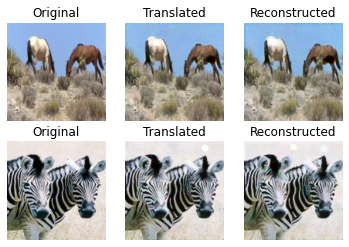

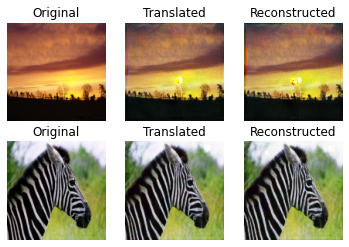

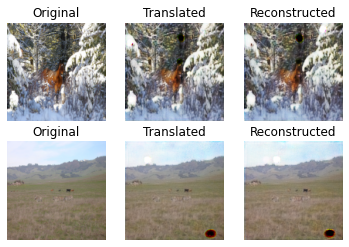

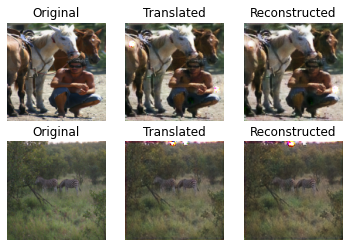

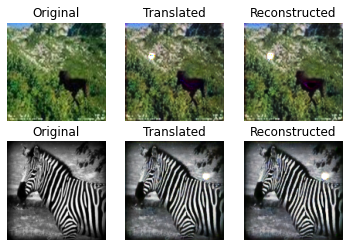

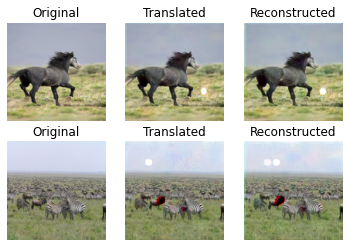

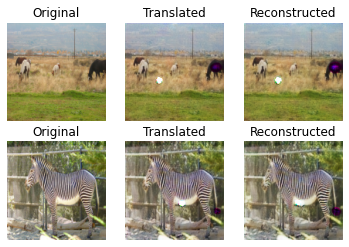

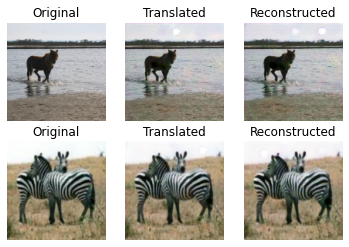

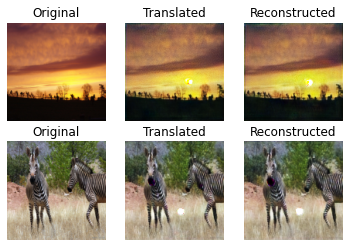

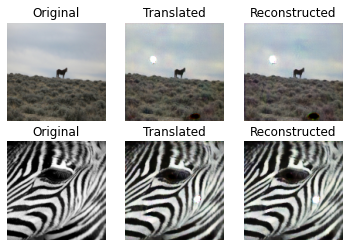

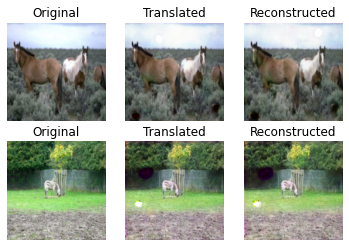

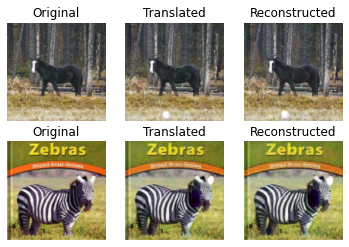

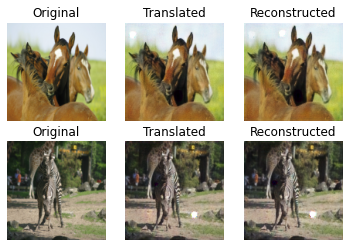

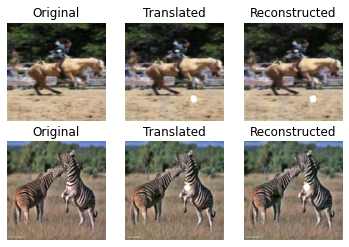

In [ ]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=1000000, batch_size=16, sample_interval=10)